# Solving The Checkerboard Artifacts In Image Deconvolution
This notebook demonstrate the NormConvTranspose2d implementation and the results of the EDSR and WDSR
networks which were trained using this new approach

Start by installing all dependencies (if your env contain the required dependencies, skip this part).
This notebook relies on the project's code, so make sure it is available to your jupyter server.

In [3]:
!pip3 install torch --user -q
!pip3 install matplotlib --user -q
!pip3 install tqdm --user -q

Import the required libs

In [6]:
!pip3 list
import tqdm
import numpy as np
from torch import nn
import torch
import matplotlib.pyplot as plt

Package                Version
---------------------- -------------------
absl-py                0.10.0
boto3                  1.14.47
botocore               1.17.47
brotlipy               0.7.0
bson                   0.5.10
cachetools             4.1.1
certifi                2020.6.20
cffi                   1.14.1
chardet                3.0.4
click                  7.1.2
cryptography           2.9.2
cycler                 0.10.0
docutils               0.15.2
Flask                  1.1.2
future                 0.18.2
google-auth            1.21.0
google-auth-oauthlib   0.4.1
grpcio                 1.31.0
h5py                   2.10.0
idna                   2.10
importlib-metadata     1.7.0
itsdangerous           1.1.0
Jinja2                 2.11.2
jmespath               0.10.0
kiwisolver             1.2.0
Markdown               3.2.2
MarkupSafe             1.1.1
matplotlib             3.3.1
mkl-fft                1.1.0
mkl-random             1.1.1
mkl-service            2.3.0
names    

ModuleNotFoundError: No module named 'tqdm'

We will start with a simple demonstration of the normalization of the deconvolution.

We define two deconvolutions layers:
 - one using nn.ConvTranspose2d implementation
 - one with our own implementation - NormConvTranspose2d

We initialize both with the same weights and biases to be able to properly compare between them.
We initialize with a flat value convolution and with bias 0.

In [12]:
from core.model.NormConvTranspose2d import NormConvTranspose2d

deconv = nn.ConvTranspose2d(3, 3, kernel_size=5, stride=4, padding=2, output_padding=3)
norm_deconv = NormConvTranspose2d(3, 3, kernel_size=5, stride=4, padding=2, output_padding=3)

deconv.weight.data.fill_(0.4)
norm_deconv.weight.data.fill_(0.4)
deconv.bias.data.fill_(0)
norm_deconv.bias.data.fill_(0)


tensor([0., 0., 0.])

For the following experiment demonstration, we convolve a 20x20x3 homogeneous color image with the two deconvolutions.<br>

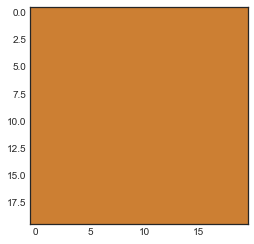

In [13]:
img = torch.zeros((1, 3,20,20))
img[0][0] = 0.8
img[0][1] = 0.5
img[0][2] = 0.2

plt.imshow(img.squeeze().permute(1, 2, 0))

We would expect to see checkerboard artifacts in the nn.ConvTranspose2d results.<br>
In our NormConvTranspose2d, we would expect to see mitigated artifacts.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


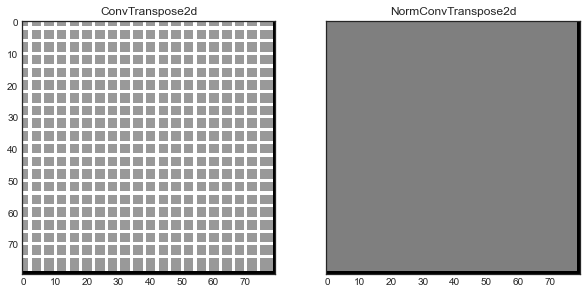

In [14]:
%matplotlib inline
plt.style.use('seaborn-white')

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=[10, 7])
res_deconv = deconv(img)
res_norm_deconv = norm_deconv(img)
ax[0].imshow(res_deconv.squeeze().permute(1, 2, 0).detach())
ax[0].title.set_text("ConvTranspose2d")
ax[1].imshow(res_norm_deconv.squeeze().permute(1, 2, 0).detach())
ax[1].title.set_text("NormConvTranspose2d")

One can easily see, when comparing the results of ConvTranspose2d implementation with NormConvTranspose2d implementation that the checkerboard artifacts are mitigated.<br>
This implies that notion of adding a normalization step is indeed beneficial.



# EDSR Model

We have implemented and trained the EDSR and WDSR models with Deconvolution and Normalized Deconvolution.<br>
The results are also brought in the attached paper and the github repository.<br><br><br><br>
## Results
![Results](./images/result_examples.png)

## Run the model
The pretrained models are available on S3.<br>
To run an evaluation test, please download an EDSR model file and place it in you local drive.

In [15]:
!wget s3://deconv-pretrained/EDSR-Norm-Deconv-f128-b32-r4-x4-new-best.pth.tar .


zsh:1: command not found: wget


Then, run the following cell:

In [16]:
from core.EDSR.edsr import EDSR
from argparse import Namespace
from eval import test
from core.utils import *
from core.data.dir_dataset import DirDataSet
from torch.utils.data.dataloader import DataLoader


args = Namespace(augment_patch=True, batch_size=16,
                 checkpoint_file='./EDSR-Norm-Deconv-f128-b32-r4-x4-new-best.pth.tar',
                 dataset_dir='data/div2k/', debug=False, deconv=True, epochs=300,
                 expansion_ratio=4, iterations_per_epoch=1000, low_rank_ratio=0.8,
                 lr=0.001, lr_decay_gamma=0.5, lr_decay_steps=200,
                 model='EDSR-Norm-Deconv', n_feats=128, n_res_blocks=32, norm=True,
                 num_workers=4, output_dir='images/results/',
                 patch_size=96, res_scale=1.0, rgb_mean=[0.4488, 0.4371, 0.404],
                 rgb_range=(0.0, 255.0), scale=4, seed=1, self_ensemble=False,
                 subtract_mean=True)

model = EDSR(args).to('cpu')

# Load weights
model = load_weights(model, load_checkpoint(args.checkpoint_file)['state_dict'])

# Prepare dataset
dataset = DirDataSet('images/sample')
#dataset = DIV2K(args, train=False)
dataloader = DataLoader(dataset=dataset, batch_size=1)

test(dataset, dataloader, model, args, 'cpu')

ModuleNotFoundError: No module named 'tqdm'